This notebook compares the performance of two methods of assembling a detector image: iterating over tiles (as EXtra-geom already does), and creating and using a pixel mapping. The method already in use appears to be faster.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from karabo_data import RunDirectory, stack_detector_data
from extra_geom import AGIPD_1MGeometry

Fetch AGIPD detector data for one pulse to test with:

In [2]:
run = RunDirectory('/gpfs/exfel/exp/SPB/201831/p900039/proc/r0273/')

In [3]:
tid, train_data = run.select('*/DET/*', 'image.data').train_from_index(60)

In [4]:
stacked = stack_detector_data(train_data, 'image.data')
stacked_pulse = stacked[10]
stacked_pulse.shape

(16, 512, 128)

In [5]:
geom = AGIPD_1MGeometry.from_quad_positions(quad_pos=[
        (-525, 625),
        (-550, -10),
        (520, -160),
        (542.5, 475),
    ])

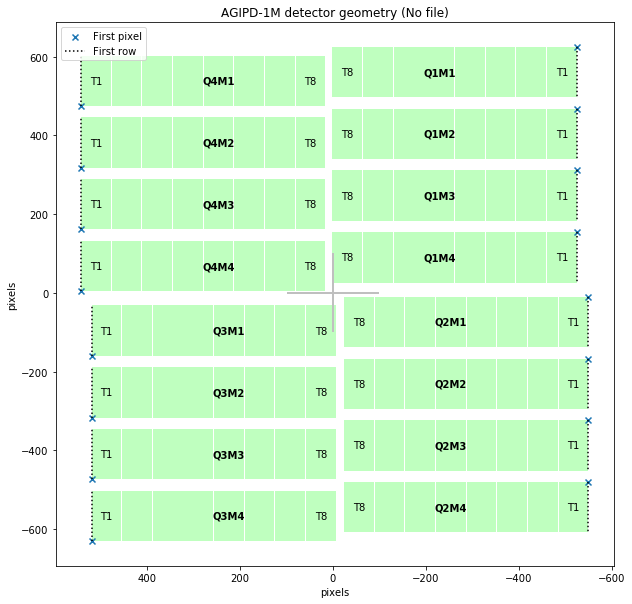

In [6]:
geom.inspect()

## Iterating over tiles

First, let's assemble and plot the data as a check that it's working.

The `position_modules_fast()` method in EXtra-geom works by iterating over the tiles defined in the geometry.

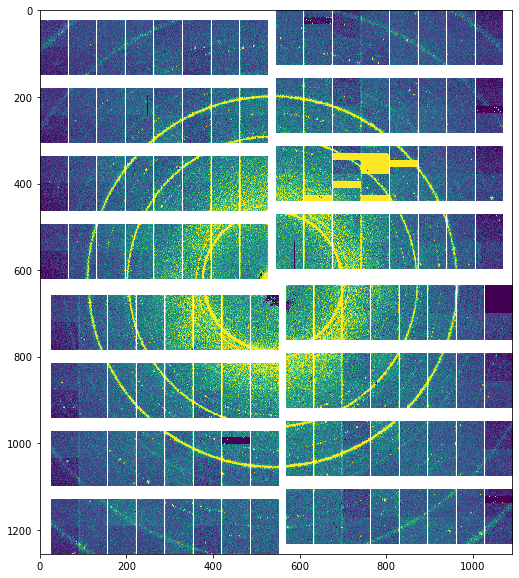

In [7]:
data, centre_yx = geom.position_modules_fast(stacked_pulse)
plt.figure(figsize=(10,  10))
plt.imshow(data, vmin=0, vmax=1000)

Now, let's time this procedure.
(The first run may take longer, because 'snapped' tiles are cached)

In [8]:
%%timeit
data, centre_yx = geom.position_modules_fast(stacked_pulse)

2.44 ms ± 4.89 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Pixel mappings

We want to make arrays of matching pixel coordinates for the input and output arrays. First, the input (stacked data) array:

In [9]:
data_indices = np.indices(geom.expected_data_shape)

In [10]:
positioned_indices, _ = geom.position_modules_fast(data_indices.astype(float))
positioned_indices.shape

(3, 1256, 1092)

In [11]:
output_shape = positioned_indices.shape[1:]

Display the assembled input coordinates to check they make sense:

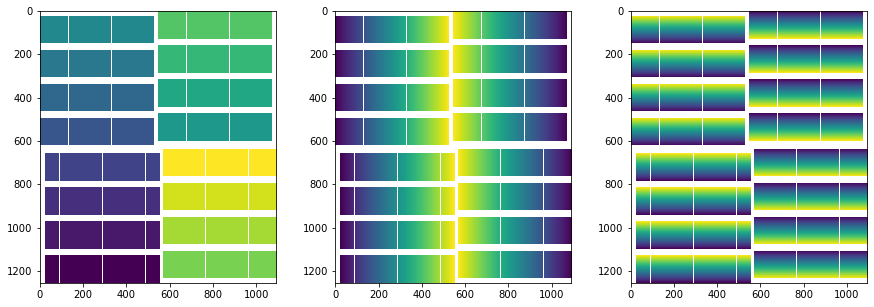

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(positioned_indices[0])
axes[1].imshow(positioned_indices[1])
axes[2].imshow(positioned_indices[2])

Now reshape them to a simple list of coordinates, and select only the pixels which have an input coordinate (not gaps):

In [13]:
src_indices = positioned_indices.reshape(3, -1)

select_pixels = ~np.isnan(src_indices[0])

src_sel_indicies = tuple(src_indices[:, select_pixels].astype(int))

The pixels can be selected in the correct order by indexing the stacked data:

In [14]:
stacked_pulse[src_sel_indicies].shape

(1048576,)

Now we need the corresponding pixel coordinates in the output array.
Again, we'll reshape these to get a list of coordinates:

In [15]:
dest_indices = np.indices(output_shape).reshape(2, -1)
dest_indices.shape

(2, 1371552)

And select only the pixels we'll be filling:

In [16]:
dest_sel_indices = tuple(dest_indices[:, select_pixels])
dest_sel_indices[0].shape

(1048576,)

Now, fill an output array and check that it looks right:

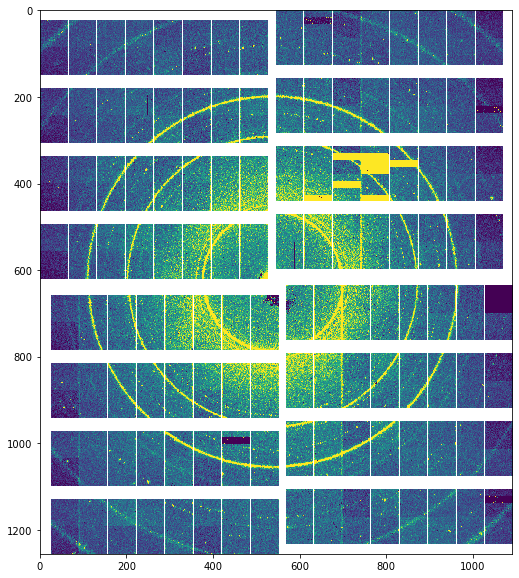

In [17]:
res = np.full(output_shape, np.nan)
res[dest_sel_indices] = stacked_pulse[src_sel_indicies]

plt.figure(figsize=(10, 10))
plt.imshow(res, vmin=0, vmax=1000)

And time this method:

In [18]:
%%timeit
res = np.full(output_shape, np.nan)
res[dest_sel_indices] = stacked_pulse[src_sel_indicies]

17.5 ms ± 9.65 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Single-step mapping

The method above creates an unnecessary copy, reordering the data before filling it into the output array.
It should be possible to do both in one step.

First, we'll convert the data coordinates of each pixel in the output into 1D indices into the source data,
and take only the pixels for which there is data.

In [19]:
src_indices_flat = (
    positioned_indices * np.array([512 * 128, 128, 1]).reshape(3, 1, 1)
).sum(axis=0).ravel()
src_sel_indices_flat = src_indices_flat[select_pixels].astype(int)
src_sel_indices_flat

array([786304, 786176, 786048, ...,  65152,  65280,  65408])

The array above maps from output pixels to input data indices.
But we want the input data in order, mapped to the output pixels.
So we'll invert it:

In [20]:
pixel_ordering = np.zeros(16 * 512 * 128, dtype=np.int)
pixel_ordering[src_sel_indices_flat] = np.arange(16 * 512 * 128)
pixel_ordering

array([1048064, 1047552, 1047040, ...,  641536,  642560,  643584])

Here are the destination pixel coordinates we used above:

In [21]:
dest_sel_indices

(array([   0,    0,    0, ..., 1255, 1255, 1255]),
 array([544, 545, 546, ..., 548, 549, 550]))

Now we reorder them to match the input data order:

In [22]:
dest_sel_indices_reordered = tuple(dest_indices[:, select_pixels][:, pixel_ordering])
dest_sel_indices_reordered

(array([1255, 1254, 1253, ...,  760,  761,  762]),
 array([ 25,  25,  25, ..., 567, 567, 567]))

Check that assembling works:

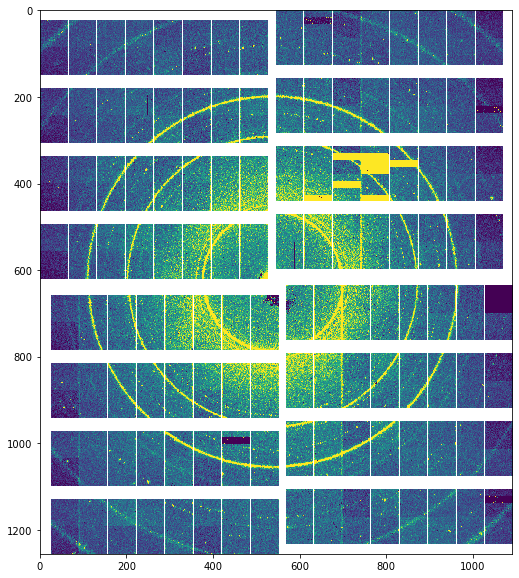

In [23]:
res = np.full(output_shape, np.nan)
res[dest_sel_indices_reordered] = stacked_pulse.ravel()

plt.figure(figsize=(10, 10))
plt.imshow(res, vmin=0, vmax=1000)

And time this method:

In [24]:
%%timeit
res = np.full(output_shape, np.nan)
res[dest_sel_indices_reordered] = stacked_pulse.ravel()

9.56 ms ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
